In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.stattools import jarque_bera
from pykalman import KalmanFilter
import multiprocess as mp
import time
import pmdarima as pm
import yfinance as yf
from math import floor

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [218]:
LEVERAGE = 1
INVERT_STRATEGY = False
# Intrady Trading: Buy and sell on the same day
# e.g. Buy on Open, Sell on Close
INTRADAY_TRADING = True
# import ticker
# TICKER = [x, y]
TICKER = ["NWSA", "NWS"]
# TICKER = ["GOOG", "GOOGL"]
START_DATE = '2023-01-01'
END_DATE = '2024-01-01'
prices = yf.download(TICKER+["SPY"], start=START_DATE, end=END_DATE)

prices_close = prices['Close']
prices_close = prices_close.dropna()
prices_close = prices_close[TICKER]


prices = prices['Open']
prices = prices.dropna()

# split into selected ticker and spy
spy = prices['SPY']
prices = prices.drop('SPY', axis=1)
# arrange data in order of ticker
prices = prices[TICKER]

# calculate daily return of SPY
spy_daily_return = spy.pct_change()


[*********************100%***********************]  3 of 3 completed


In [219]:
# split into train and test
train_size = floor(len(prices)*0.6)
train_size = len(prices.loc[:'2023-04-01'])
train, test = prices.iloc[:train_size, :], prices.iloc[train_size:, :]
x_train, x_test = train.iloc[:, 0], test.iloc[:, 0]
y_train, y_test = train.iloc[:, 1], test.iloc[:, 1]

In [221]:
# Use AR model to find the hedge ratio
log_x_train = np.log(x_train)
log_y_train = np.log(y_train)
log_x_test = np.log(x_test)
log_y_test = np.log(y_test)

# log(x)-log(y) = log(beta) + s, where s noise
log_beta_train = log_y_train-log_x_train
log_beta_test = log_y_test-log_x_test

# https://alkaline-ml.com/pmdarima/tips_and_tricks.html
# test if ARIMA is appropriate to estimate beta
model = pm.auto_arima(log_beta_train.values, start_p=1, start_q=1, max_p=5, max_q=5, m=1, seasonal=True, trace=True)
# model = pm.auto_arima(log_beta, m=12, seasonal=True, trace=True) 
    
def define_arima_class(model) -> pm.arima.arima.ARIMA:
    """
    Define ARIMA class based on the model
    """
    return model

model = define_arima_class(model)

# https://analyzingalpha.com/interpret-arima-results
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-499.415, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-487.477, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-496.024, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-502.064, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-489.460, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-499.122, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-497.974, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-504.043, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-501.347, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-501.079, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-498.014, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-499.253, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.199 seconds
                               SARIMAX Results                                
Dep. Vari

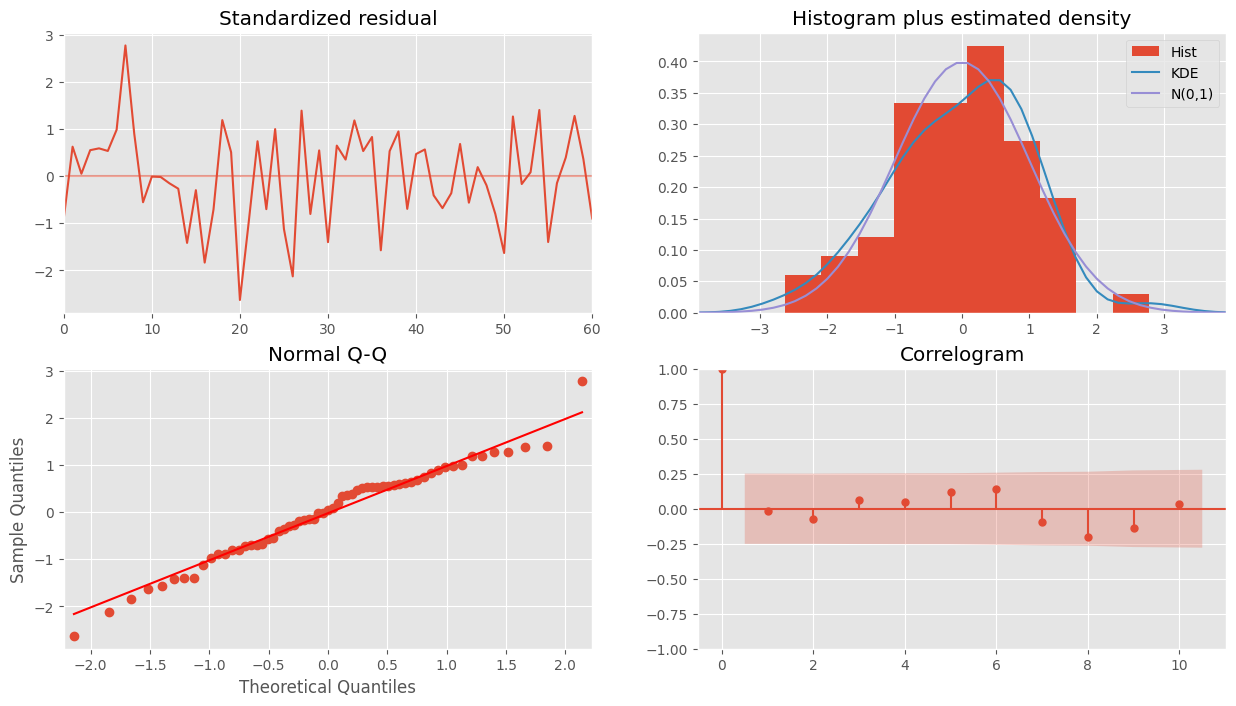

In [222]:
# aic plot
model.plot_diagnostics(figsize=(15,8))
plt.show()


In [223]:
# # find order of integration of log_x_train and log_y_train using kpss test
# ndiffs_x = pm.arima.ndiffs(log_x_train, alpha=0.05, test='kpss', max_d=6)
# ndiffs_y = pm.arima.ndiffs(log_y_train, alpha=0.05, test='kpss', max_d=6)
# print("ndiffs_x: ", ndiffs_x)
# print("ndiffs_y: ", ndiffs_y)
# if ndiffs_x != ndiffs_y:
#     raise Exception("ndiffs_x != ndiffs_y")

# # do OLS on log_x_train and log_y_train
# model = sm.OLS(log_y_train.diff(ndiffs_y).dropna()
#                , log_x_train.diff(ndiffs_x).dropna())
# results = model.fit()
# residuals = results.resid

# # Augmented Dickey-Fuller test / Cointegration test
# # https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html
# adf_result = adfuller(residuals)
# print("ADF test result: ", adf_result)
# aeg_result = coint(log_x_train.diff(ndiffs_x).dropna(), log_y_train.diff(ndiffs_y).dropna())
# print("AEG test result: ", aeg_result)
# kpss_result = sm.tsa.stattools.kpss(residuals)
# print("KPSS test result: ", kpss_result)

In [224]:
# get the p, d, q from the model
p = model.order[0]
d = model.order[1]
q = model.order[2]


# model_coeffs = dict(zip(model.arima_res_.param_names, model.params()))

pred_log_beta_train = model.predict_in_sample()
# set the first few predictions to be NaN
to_skip = max(p, d, q)
pred_log_beta_train[:to_skip] = np.nan

# get the variance of the residuals sigma^2
pred_log_sigma2_train = np.ones(len(log_beta_train))*model.params()[-1]

# get the intercept
# if model.with_intercept:
#     intercept = 
# else:
#     intercept = 0

# predict the test set
pred_log_beta_test = np.zeros(len(log_beta_test))
pred_log_sigma2_test = np.zeros(len(log_beta_test))
for i in range(len(log_beta_test)):
    pred_log_beta_test[i] = model.predict(n_periods=1)[0]
    pred_log_sigma2_test[i] = model.params()[-1]
    
    # update the model after prediction to prevent forward-looking bias
    model.update(log_beta_test[i])

# convert logs to original prices
pred_beta_train = np.exp(pred_log_beta_train)
pred_beta_test = np.exp(pred_log_beta_test)
pred_sigma2_train = np.exp(pred_log_sigma2_train)
pred_sigma2_test = np.exp(pred_log_sigma2_test)

Text(0, 0.5, 'NWS')

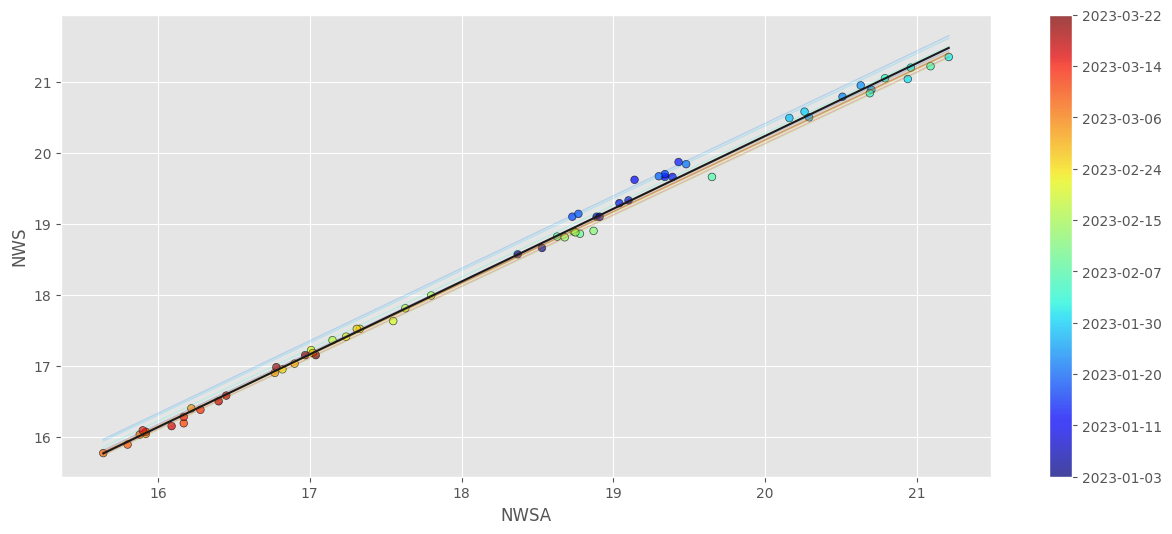

In [225]:
from scipy import poly1d

# Plot data points using colormap
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(x_train))
sc = plt.scatter(x_train, y_train, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x_train[::len(x_train)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x_train.min(), x_train.max(), 2)
colors_l = np.linspace(0.1, 1, len(pred_beta_train[::step]))
for i, beta in enumerate(pred_beta_train[::step]):
    plt.plot(xi, beta * xi , alpha=.2, lw=1, c=cm(colors_l[i]))
    
# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x_train, y_train, 1))(xi), '0.1')

# Label axes
plt.xlabel(TICKER[0])
plt.ylabel(TICKER[1])

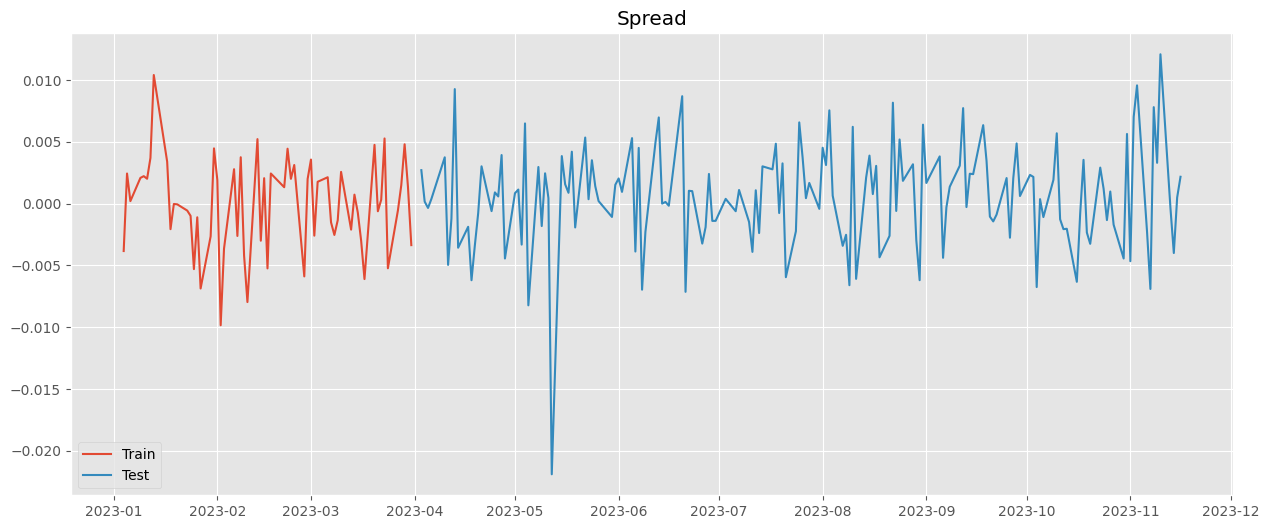

In [226]:
log_spread_train = log_y_train - log_x_train - pred_log_beta_train
log_spread_test = log_y_test - log_x_test - pred_log_beta_test

# plot the spread
plt.figure()
plt.plot(log_spread_train)
plt.plot(log_spread_test)
plt.title("Spread")
plt.legend(["Train", "Test"])
plt.show()


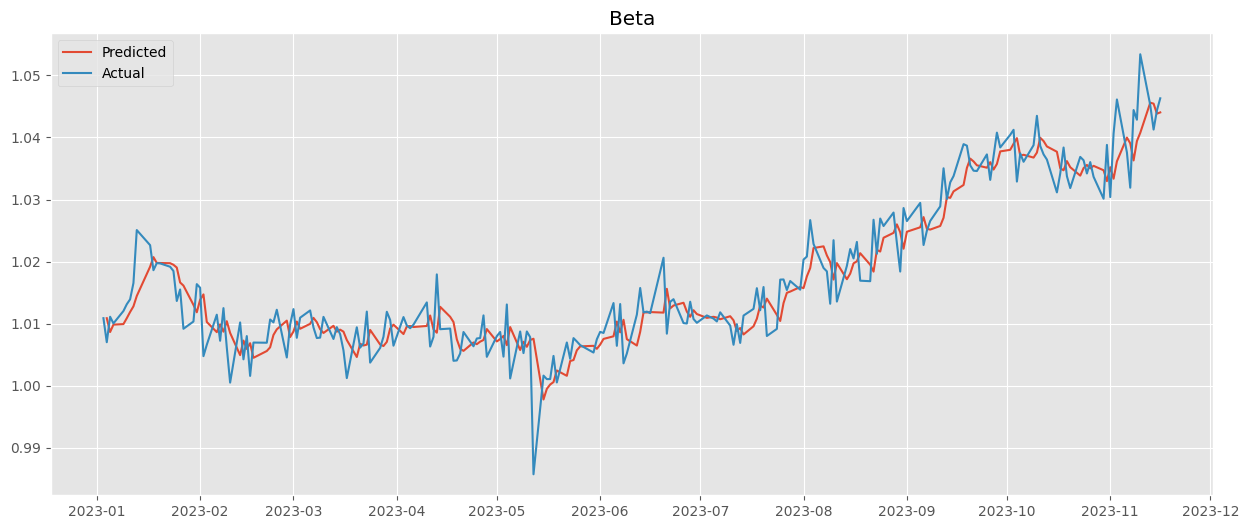

In [227]:
# plot the predicted beta and the actual beta
pred_beta = np.append(pred_beta_train, pred_beta_test)
pred_beta = pd.Series(pred_beta, index=prices.index)
beta = np.exp(np.append(log_beta_train, log_beta_test))
beta = pd.Series(beta, index=prices.index)
plt.figure()
plt.plot(pred_beta)
plt.plot(beta)
plt.title("Beta")
plt.legend(["Predicted", "Actual"])
plt.show()



In [228]:
def statistic_test(resid, to_skip=0):
    # ljung-box test for autocorrelation
    pvalue= sm.stats.acorr_ljungbox(resid[to_skip:])['lb_pvalue'].values[0]
    print("p-value for ljung-box test: {}".format(pvalue))
    if pvalue < 0.05:
        print('Residue is autocorrelated')
    else:
        print('Residue is not autocorrelated')

    #check for normality of spread
    _, pvalue, _, _ = jarque_bera(resid[to_skip:])
    print('p-value for jarque-bera test: {}'.format(pvalue))
    if pvalue < 0.05:
        print('Residue is not normal')
    else:
        print('Residue is normal')
        
    #check for heteroskedasticity of spread 2 sided
    # test whether the variance of the residuals is dependent on the level of the series
    # meaning the variance of the residuals is not constant
    _, pvalue, _, _ = het_arch(resid[to_skip:])
    print('p-value for het_arch test: {}'.format(pvalue))
    if pvalue < 0.05:
        print('Residue is heteroskedastic')
    else:
        print('Residue is not heteroskedastic')


print("===================== Train set =====================")
statistic_test(log_spread_train, to_skip=to_skip)
print("===================== Test set =====================")
statistic_test(log_spread_test, to_skip=0)
    


===================== Train set =====================
p-value for ljung-box test: 0.9089780444375632
Residue is not autocorrelated
p-value for jarque-bera test: 0.8098081583455469
Residue is normal
p-value for het_arch test: 0.6742299046322864
Residue is not heteroskedastic
===================== Test set =====================
p-value for ljung-box test: 0.09583967327757255
Residue is not autocorrelated
p-value for jarque-bera test: 2.401848403659329e-28
Residue is not normal
p-value for het_arch test: 0.9467443463574319
Residue is not heteroskedastic


##  spread = Y - hedgeRatio * X 
## log(Y) - log(X) = sigma + log(hedgeRatio)
<br>
The error is place inside the hedge ratio

In [229]:
# state_vars = spread_train.ewm(span=30).var()
pred_log_vars = np.append(pred_log_sigma2_train, pred_log_sigma2_test)
pred_log_sigma = np.sqrt(pred_log_vars)
e = np.append(log_spread_train, log_spread_test)

# temp = prices
# prices = prices_close
# e = np.log(prices_close[TICKER[1]]) - np.log(prices_close[TICKER[0]]) - np.log(pred_beta)

# Set initial positions to 0
columns = ['positions_'+TICKER[0]+'_long', 'positions_'+TICKER[0]+'_short', 'positions_'+TICKER[1]+'_long', 'positions_'+TICKER[1]+'_short']
for column in columns:
    prices[column] = 0

# Entry conditions based on sqrt_Qt
entry_threshold = 0*pred_log_sigma  # Replace with your specific calculation of sqrt_Qt

# Short entry
prices.loc[e > entry_threshold , ('positions_'+TICKER[0]+'_short', 'positions_'+TICKER[1]+'_short')] = [1, -1]

# Long entry
prices.loc[e < -entry_threshold, ('positions_'+TICKER[0]+'_long', 'positions_'+TICKER[1]+'_long')] = [-1, 1]


# Exit conditions based on sqrt_Qt
exit_threshold = 0*pred_log_sigma  # Set your desired exit threshold

# let entry threshold be 1 standard deviations from rolling standard deviation
# exit_threshold = 0*spread.rolling(lookback).std()

# Close short position
prices.loc[e < exit_threshold, ('positions_'+TICKER[0]+'_short', 'positions_'+TICKER[1]+'_short')] = 0

# Close long position
prices.loc[e > -exit_threshold, ('positions_'+TICKER[0]+'_long', 'positions_'+TICKER[1]+'_long')] = 0


# ensure existing positions are carried forward
prices.fillna(method='ffill', inplace=True)


In [230]:
positions_long = prices.loc[:,('positions_'+TICKER[0]+'_long', 'positions_'+TICKER[1]+'_long')]
positions_short = prices.loc[:,('positions_'+TICKER[0]+'_short', 'positions_'+TICKER[1]+'_short')]

positions = np.array(positions_long) + np.array(positions_short)
if INVERT_STRATEGY:
    positions = -positions
positions = pd.DataFrame(positions, index=prices.index, columns=['positions_'+TICKER[0], 'positions_'+TICKER[1]])

positions_sign = positions.copy()

# multiply sposition of TickX by hedge ratio to get amount of TickX to equalize TickY
positions['positions_'+TICKER[0]] = positions['positions_'+TICKER[0]] * np.append(pred_beta_train, pred_beta_test)

# multiply positions by price to get dollar position
positions["positions_"+TICKER[0]] = positions['positions_'+TICKER[0]] * prices[TICKER[0]]
positions["positions_"+TICKER[1]] = positions['positions_'+TICKER[1]] * prices[TICKER[1]]



In [231]:
# Intraday Trading: Buy and sell on the same day
# In this scenario: Buy on open, sell on close
if INTRADAY_TRADING:
    intraday_daily_returns = (prices_close - prices[TICKER])/prices[TICKER]

    # calculate weighted returns based on positions
    pnl = (np.array(positions) * np.array(intraday_daily_returns)).sum(axis=1)

    daily_used_capital = np.sum(np.abs(positions), axis=1)/2/LEVERAGE
    transaction_pct_cost = 0.0005
    transaction_costs = np.sum(np.abs(positions), axis=1)*transaction_pct_cost

    # Intraday Trading is always daily rebalanced
    # DAILY_REBALANCE = False
    # if not DAILY_REBALANCE:
    #     # ignore transaction costs if positions_sign is not changed from previous day
    #     transaction_costs_bool = (positions_sign == positions_sign.shift()).any(axis=1)
    #     transaction_costs[transaction_costs_bool] = 0

    # subtract transaction costs
    pnl_with_cost = (pnl - transaction_costs)/daily_used_capital
    pnl_with_cost = pnl_with_cost.fillna(0)

    # calculate the percentage returns
    pct_pnl = pnl / daily_used_capital

    # if pnl is nan, set to 0
    pct_pnl = pct_pnl.fillna(0)

else:
    # get daily returns
    daily_returns = prices.pct_change()[TICKER]

    # calculate weighted returns based on positions
    pnl = (np.array(positions.shift()) * np.array(daily_returns)).sum(axis=1)

    daily_used_capital = np.sum(np.abs(positions), axis=1)/2/LEVERAGE
    transaction_pct_cost = 0.0005
    transaction_costs = np.sum(np.abs(positions), axis=1)*transaction_pct_cost

    # TODO: Daily Rebalance is not complete as it has to accoutn for the unchanged positions
    DAILY_REBALANCE = False
    if not DAILY_REBALANCE:
        # ignore transaction costs if positions_sign is not changed from previous day
        transaction_costs_bool = (positions_sign == positions_sign.shift()).any(axis=1)
        transaction_costs[transaction_costs_bool] = 0

    # subtract transaction costs
    pnl_with_cost = (pnl - transaction_costs.shift())/daily_used_capital.shift()
    pnl_with_cost = pnl_with_cost.fillna(0)

    # calculate the percentage returns
    pct_pnl = pnl / daily_used_capital.shift()

    # if pnl is nan, set to 0
    pct_pnl = pct_pnl.fillna(0)

In [232]:
# def rolling_sharpe(pnl, rolling_period=100):
#     return np.sqrt(252) * pnl.rolling(rolling_period).mean() / pnl.rolling(rolling_period).std()


# def rolling_sortino(pnl, rolling_period=100):
#     return np.sqrt(252) * pnl.rolling(rolling_period).mean() / pnl[pnl<0].rolling(rolling_period).std()

# sharpe_list = [0]
# for i in range(1, 100):
#     # test optimal lookback period
#     lookback = i
#     copy = pnl_with_cost.copy()
#     rolling_sharpe_strat = rolling_sortino(copy,lookback)
#     copy[rolling_sharpe_strat.shift(2)<1] = 0
#     sharpe = np.sqrt(252) * copy[1:].mean() / copy[1:].std()
#     sharpe_list.append(sharpe)

# # plot sharpe ratio
# plt.plot(sharpe_list)

# print(max(sharpe_list), np.argmax(sharpe_list))
    

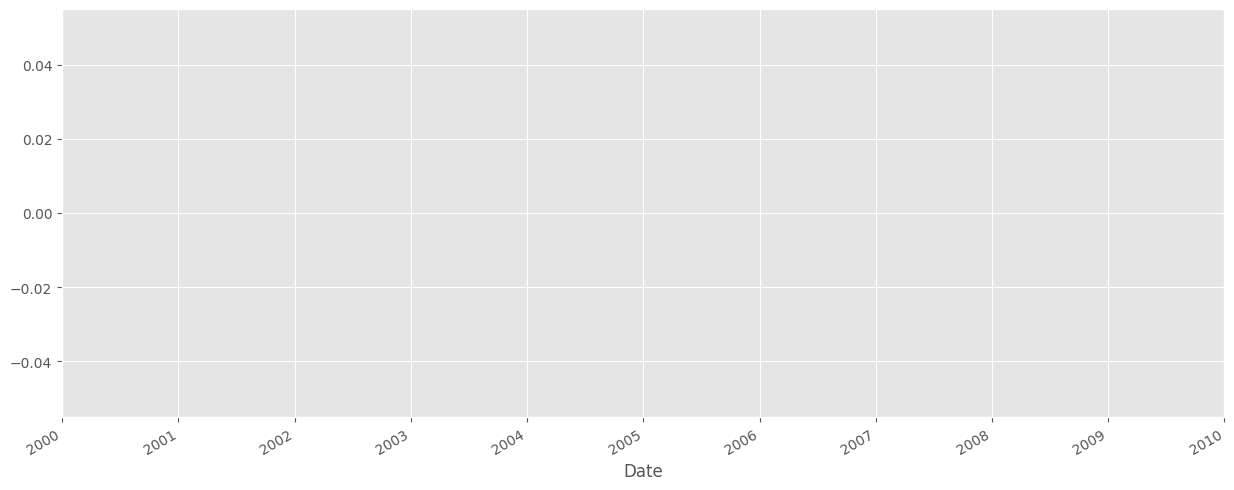

In [233]:
# plot rolling sharpe ratio

def rolling_sharpe(pnl, rolling_period=100):
    return np.sqrt(252) * pnl.rolling(rolling_period).mean() / pnl.rolling(rolling_period).std()

def rolling_sortino(pnl, rolling_period=100):
    return np.sqrt(252) * pnl.rolling(rolling_period).mean() / pnl[pnl<0].rolling(rolling_period).std()

# set to 0 to ignore sharpe ratio
rolling_period = 0

rolling_sortino(pct_pnl,rolling_period).plot()

# set the pnl to 0 when the rolling sharpe ratio is below 1
rolling_sharpe_strat = rolling_sortino(pct_pnl,rolling_period)

# .shift() to shift the rolling sharpe ratio by 1 day to avoid look ahead bias
# yesterday's rolling sharpe ratio affect today's position decision
positions[rolling_sharpe_strat.shift(1) < 1]= 0

# .shift(2) to shift the rolling sharpe ratio by 2 days to avoid look ahead bias of pnl 
# shift(2) as rolling sharpe affect today's position which affect tomorrow's pnl
pct_pnl[rolling_sharpe_strat.shift(2)<1] = 0
pnl_with_cost[rolling_sharpe_strat.shift(2)<1] = 0


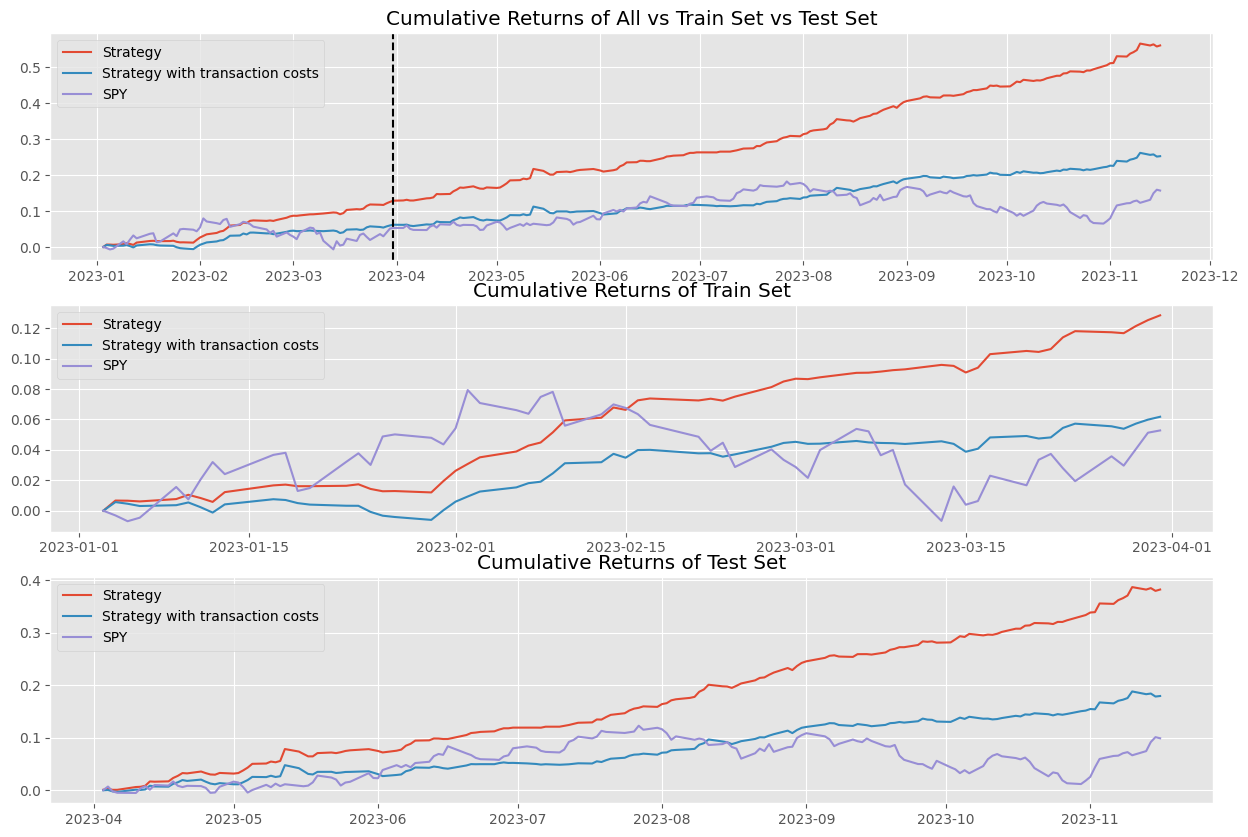

In [234]:
strats = pd.concat([pct_pnl, pnl_with_cost,spy_daily_return.fillna(0)], axis=1)
strats.columns = ['Strategy', 'Strategy with transaction costs', 'SPY']
strats_train = strats[:train_size]
strats_test = strats[train_size:]
#set strats_test first row to 0
strats_test['SPY'].iloc[0] = 0
if not INTRADAY_TRADING:
    strats_test['Strategy'].iloc[0] = 0
    strats_test['Strategy with transaction costs'].iloc[0] = 0


#create cumulative returns of strategies
strats_cum = (strats + 1).cumprod()-1
strats_train_cum = (strats_train + 1).cumprod()-1
strats_test_cum = (strats_test + 1).cumprod()-1

#plot cumulative returns of all vs train set vs test set in 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
ax1.plot(strats_cum)
# draw vertical line to separate train and test set
ax1.axvline(strats_train_cum.index[-1], color='k', linestyle='--')
ax1.legend(['Strategy', 'Strategy with transaction costs', 'SPY'])
ax1.title.set_text('Cumulative Returns of All vs Train Set vs Test Set')
ax2.plot(strats_train_cum)
ax2.legend(['Strategy', 'Strategy with transaction costs', 'SPY'])
ax2.title.set_text('Cumulative Returns of Train Set')
ax3.plot(strats_test_cum)
ax3.legend(['Strategy', 'Strategy with transaction costs', 'SPY'])
ax3.title.set_text('Cumulative Returns of Test Set')
plt.show()



In [235]:
# count number of trades per year
trades = pd.DataFrame(positions_sign, index=prices.index, columns=['positions_'+TICKER[0], 'positions_'+TICKER[1]])
trades = trades.loc[trades.any(axis=1)].iloc[:,0]
total_trades = trades.groupby(trades.index.year).count()
total_trades


Date
2023    220
Name: positions_NWSA, dtype: int64

In [236]:
def calculate_sharpe_ratio(returns :pd.Series) -> float:
    return np.sqrt(252) * returns.mean() / returns.std()

def calculate_sortino_ratio(returns :pd.Series) -> float:
    return np.sqrt(252) * returns.mean() / returns[returns<0].std()

def calculate_drawdown(returns: pd.Series) -> tuple:
    # calculate a cumulative wealth index
    wealth_index = (1 + returns).cumprod()

    # calculate previous peaks
    previous_peaks = wealth_index.cummax()

    # calculate drawdown
    drawdown = (wealth_index - previous_peaks) / previous_peaks
    max_drawdown = drawdown.min()
    max_drawdown_period = drawdown.idxmin()

    return drawdown, max_drawdown, max_drawdown_period

def calculate_annualized_return(returns: pd.Series) -> float:
    cumulative_returns=(1+returns).cumprod()
    n_years = len(cumulative_returns)/252
    return (cumulative_returns.iloc[-1])**(1/n_years)-1

def calmar_ratio(returns: pd.Series) -> float:
    _, max_drawdown, _ = calculate_drawdown(returns)
    annualized_return = calculate_annualized_return(returns)
    return annualized_return / abs(max_drawdown)
    

In [237]:
strat_sets  = {'All': strats, 'Train': strats_train, 'Test': strats_test}

In [238]:
# calculate sharpe ratio, sortino ratio, drawdown, max drawdown, max drawdown period, annualized return, calmar ratio
sharpe_ratios = {}
sortino_ratios = {}
drawdowns = {}
max_drawdowns = {}
max_drawdown_periods = {}
annualized_returns = {}
calmar_ratios = {}

for key, value in strat_sets.items():
    sharpe_ratio = calculate_sharpe_ratio(value)
    sortino_ratio = calculate_sortino_ratio(value)
    drawdown, max_drawdown, max_drawdown_period = calculate_drawdown(value)
    annualized_return = calculate_annualized_return(value)
    calmar = calmar_ratio(value)
    print(f'=============================={key} set============================================================')
    print(f'Sharpe Ratio:\n{sharpe_ratio}\n')
    print(f'Sortino Ratio:\n{sortino_ratio}\n')
    print(f'Max Drawdown:\n{max_drawdown}\n')
    # print(f'Max Drawdown Period:\n{max_drawdown_period}\n')
    print(f'Annualized Return:\n{annualized_return}\n')
    print(f'Calmar Ratio:\n{calmar}\n')
    print("")
    sharpe_ratios[key] = sharpe_ratio
    sortino_ratios[key] = sortino_ratio
    drawdowns[key] = drawdown
    max_drawdowns[key] = max_drawdown
    max_drawdown_periods[key] = max_drawdown_period
    annualized_returns[key] = annualized_return
    calmar_ratios[key] = calmar

==============================All set============================================================
Sharpe Ratio:
Strategy                           10.047280
Strategy with transaction costs     5.095810
SPY                                 1.262039
dtype: float64

Sortino Ratio:
Strategy                           26.008808
Strategy with transaction costs    12.151290
SPY                                 2.160946
dtype: float64

Max Drawdown:
Strategy                          -0.012960
Strategy with transaction costs   -0.019864
SPY                               -0.099037
dtype: float64

Annualized Return:
Strategy                           0.660131
Strategy with transaction costs    0.292291
SPY                                0.180609
Name: 2023-11-16 00:00:00, dtype: float64

Calmar Ratio:
Strategy                           50.936965
Strategy with transaction costs    14.714617
SPY                                 1.823650
dtype: float64


==============================Train set==========

In [239]:
# print sharpe ratios
print("==============================Sharpe Ratios ============================================================")
for key, value in sharpe_ratios.items():
    print(f'{key} set: \n{value}\n')

# print sortino ratios
print("==============================Sortino Ratios ============================================================")
for key, value in sortino_ratios.items():
    print(f'{key} set: \n{value}\n')


# print max drawdowns
print("==============================Max Drawdowns ============================================================")
for key, value in max_drawdowns.items():
    print(f'{key} set: \n{value}\n')


# print annualized returns
print("==============================Annualized Returns ============================================================")
for key, value in annualized_returns.items():
    print(f'{key} set: \n{value}\n')

# print calmar ratios
print("==============================Calmar Ratios ============================================================")
for key, value in calmar_ratios.items():
    print(f'{key} set: \n{value}\n')


==============================Sharpe Ratios ============================================================
All set: 
Strategy                           10.047280
Strategy with transaction costs     5.095810
SPY                                 1.262039
dtype: float64

Train set: 
Strategy                           10.620371
Strategy with transaction costs     5.291418
SPY                                 1.236930
dtype: float64

Test set: 
Strategy                           9.841065
Strategy with transaction costs    5.024576
SPY                                1.313724
dtype: float64

==============================Sortino Ratios ============================================================
All set: 
Strategy                           26.008808
Strategy with transaction costs    12.151290
SPY                                 2.160946
dtype: float64

Train set: 
Strategy                           29.553379
Strategy with transaction costs    12.778654
SPY                                 2.19690

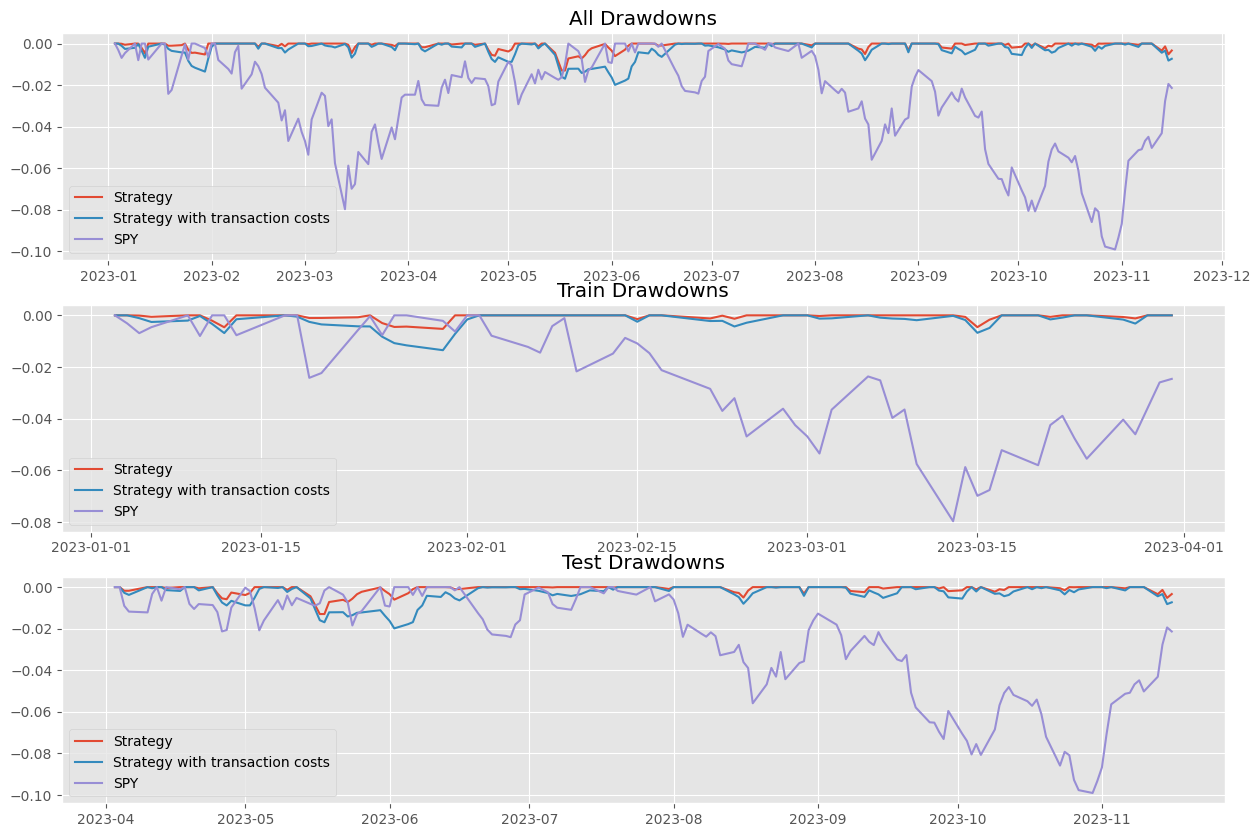

In [240]:
# plot drawdowns
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
ax1.plot(drawdowns['All'])
ax1.legend(['Strategy', 'Strategy with transaction costs', 'SPY'])
ax1.set_title('All Drawdowns')
ax2.plot(drawdowns['Train'])
ax2.legend(['Strategy', 'Strategy with transaction costs', 'SPY'])
ax2.set_title('Train Drawdowns')
ax3.plot(drawdowns['Test'])
ax3.legend(['Strategy', 'Strategy with transaction costs', 'SPY'])
ax3.set_title('Test Drawdowns')
plt.show()